In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mva_helper import * # my helper functions

plt.rcParams['figure.figsize'] = (4, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## No Bias Trick
This is the same as the "main" example but the bias nodes are explicit.

### Linear Classifier

In [2]:
X, y = blob_data(noise_level = 0.5, correlated = 0.5, N = 200)
# X, y = spiral_data(K = 5, noise_level = 0.3)

# initialize parameters randomly
K = len(set(y))
D = X.shape[1]

W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-1
reg = 1e-3 # regularization strength
epsilon = 1e-5

# gradient descent loop
num_examples = X.shape[0]
for i in range(5000): 
    
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    
    if i % 1000 == 0: print("iteration {:d}: loss {:f}".format(i, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores) + reg * W
    db = np.sum(dscores, axis=0, keepdims=True)

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

    
def linear_classifier(X):
    
    # Calculate the max classifier value.
    return np.argmax(np.dot(X, W) + b, axis = 1)   
    

iteration 0: loss 1.382120
iteration 1000: loss 0.412315
iteration 2000: loss 0.381442
iteration 3000: loss 0.372406
iteration 4000: loss 0.368914


In [3]:
### Neural Network without Bias Trick

In [4]:
import numpy as np

# Single hidden layer
class my_nn():
    
    def __init__(self, classes, dim, Nhidden = 100, step_size = 1, regularization = 1e-3):
        
        # dimensions
        self.K = classes
        self.D = dim
        self.Dh = Nhidden

        # randomly initialization
        self.W1 = 0.01 * np.random.randn(self.D, self.Dh)
        self.W2 = 0.01 * np.random.randn(self.Dh, self.K)

        # zeroes for the viases.
        self.b1 = np.zeros((1, self.Dh))
        self.b2 = np.zeros((1, self.K))

        # hyperparameters
        self.step_size = step_size 
        self.a = regularization
        
    
    def evaluate(self, X):
        
        # Useful to save the hidden layer, for back propagation.
        self.h = np.maximum(0, np.dot(X, self.W1) + self.b1) # ReLU activation
        scores = np.dot(self.h, self.W2) + self.b2
        
        return scores
 
    def classify(self, X):
        
        return np.argmax(self.evaluate(X), axis=1)

    
    def train(self, X, y, iterations = 500):
        
        N = X.shape[0]

        # gradient descent loop
        for it in range(iterations):

            # evaluate 
            scores = self.evaluate(X)
            
            # compute the class probabilities
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

            # compute the loss: average cross-entropy loss and regularization
            data_loss = np.sum(-np.log(probs[range(N),y])) / N
            regu_loss = 0.5 * self.a * (np.sum(self.W1*self.W1) + np.sum(self.W2*self.W2))
            loss = data_loss + regu_loss

            if it % 1000 == 0: print("iteration {:d}: loss {:.4f}".format(it, loss))

            # compute the gradient on scores
            df = probs
            df[range(N),y] -= 1
            df /= N

            # backpropate the gradient to the parameters
            # first backprop into parameters W2 and b2
            dW2 = np.dot(self.h.T, df)
            db2 = np.sum(df, axis=0, keepdims=True)
            
            # backprop into hidden layer
            dh = np.dot(df, self.W2.T)
            # backprop the ReLU non-linearity
            dh[self.h <= 0] = 0
            
            # finally into W1, b1
            dW1 = np.dot(X.T, dh)
            db1 = np.sum(dh, axis=0, keepdims=True)

            # add regularization gradient contribution
            # since we used α W² / 2, it's just αW.
            dW2 += self.a * self.W2
            dW1 += self.a * self.W1

            # perform a parameter update
            # step_size = 10 ** (-np.log(it+1)/np.log(5000))
            self.W1 += - self.step_size * dW1
            self.b1 += - self.step_size * db1
            self.W2 += - self.step_size * dW2
            self.b2 += - self.step_size * db2


In [5]:
X, y = spiral_data(K = 5, noise_level = 0.3, N = 5000)

iteration 0: loss 1.6095
iteration 1000: loss 0.8527
iteration 0: loss 0.8506


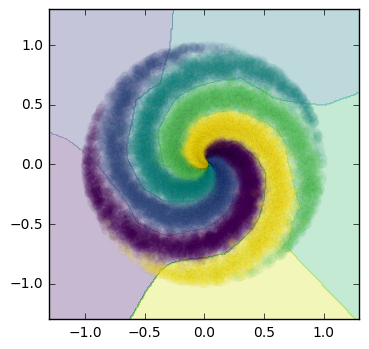

In [6]:
nn = my_nn(classes = len(set(y)), dim = X.shape[1], Nhidden = 100)
nn.train(X, y, 1001)

nn.step_size = 0.1
nn.train(X, y, 250)
plot_classifier(X[::,], y[::], fn = nn.classify, file = "my_nn_classifier.pdf", alpha = 0.3, alpha_pt = 0.05)